# Analisi verbalizzazioni

Questo *notebook* consente di svolgere alcune semplici analisi a partire dai verbali estratti tramite la funzione [Archivio verbali ed esiti finali](https://work.unimi.it/boDocenti/wicket/page?3) dell'applicazione [B.O. Docent](https://work.unimi.it/boDocenti/); più in geneale consente di svolgere le analisi a partire da un elenco di verbali d'esame che registrino, per ciascuna prova, l'*insegnamento* a cui si riferisce, la *data* in cui è avvenuta, il numero di *matricola* dello studente (o un qualunque identificatore unico del medesimo) e l'*esito* della prova.

In [194]:
# importazione delle librerie necessarie

import pandas as pd
from ipywidgets import widgets

## Lettura e preparazione dei dati

In questa sezione vengono caricati e "normalizzati" i dati che si assume siano stati ottenuti dall'esportazione sopra descritta e salvanti in un file il cui nome è memorizzato nella variabile `file_verbali`.

Eseguita l'ultima cella di questa sezione i dati saranno contenuti nella variabile `estrazione` che corrisponderà ad un *data-frame* di Pandas contenente le colonne: `Inesegnamento`, `Data`, `Matricola` ed `Esito` ed ordinato per data (l'ordine è rilevante per le aggregazioni delle prossime sezioni). Il contenuto della colonna `Eisto` è una *stringa* che codifica l'esito della prova come segue:

* `RI` corrisponde ad un ritiro,
* `RE` indica che la prova non è stata superata (ossia che l'allievo è stato respinto),
* un stringa contenente un numero intero corrisponde ad un esito verbalizzato (la stringa `33` corrisponde al voto 30 e lode),
* una stringa contenente un numero intero prefissato dal simbolo `~` corrisponde ad un esito rifiutato. 

In [195]:
file_verbali = 'verbali-esami.xls'

In [196]:
def vse2e(voto, stato_esito):
    if stato_esito == 'Rifiutato': return '~' + voto
    if voto == 'Respinto': return 'RE'
    if voto == 'Ritirato': return 'RI'
    if voto == '30 e lode': return '33'
    return voto

estrazione = pd.read_excel(file_verbali).apply(lambda _: pd.Series({
    'Insegnamento': _['Descrizione insegnamento'],
    'Data': _['Data'],
    'Matricola': _['Matricola'], 
    'Esito': vse2e(_['Voto'], _['Stato Esito'])
}), axis = 1).sort_values('Data')

In [197]:
# vengono riportate alcune linee a scopo di esempio

estrazione.head()

,Insegnamento,Data,Matricola,Esito
378,LINGUAGGI E TRADUTTORI,2019-06-28,867234,24
377,LINGUAGGI E TRADUTTORI,2019-07-11,897293,24
376,LINGUAGGI E TRADUTTORI,2019-07-11,857113,24
375,LINGUAGGI E TRADUTTORI,2019-07-23,893396,30
374,LINGUAGGI E TRADUTTORI,2019-07-23,V06539,RE


## Selezione dei dati

Eseguendo le celle di questa sezione è possibile definire alcune funzioni di utilià che possono risultare comode per selezionare i dati di uno o più appelli dalla variabile `estrazioni` ottenuta in precedenza.

In particolare, la prossima cella ottiene gli insegnamenti a cui si riferiscono gli esiti.

In [198]:
insegnamenti = sorted(set(estrazione.Insegnamento))

Le prossime due funzioni consentono di ottenere l'elenco di date dei verbali dato un insegnamento e l'elenco di verbali corrispondenti ad un certo insegnamento e data.

In [199]:
def date(insegnamento):
    return sorted(frozenset(estrazione[estrazione.Insegnamento == insegnamento].Data.dt.date))

def verbali(insegnamento, data):
    sel_data = estrazione.Data.dt.date.isin(data) if isinstance(data, tuple) else estrazione.Data.dt.date == data
    return estrazione[(estrazione.Insegnamento == insegnamento) & sel_data]

La prossima cella definisce una funzione che produce una serie di *widget* utili a selezionare un sottoinsieme di verbali in funzione dell'insegnamento e della data. La funzione restituisce un oggetto i cui attributi: `insegnamento`, `date` e `verbali` sono dinamicamente aggiornati per riflettere la selezione corrente. 

La parte a destra dei widget riporata il numero totale di verbali selezionai ed il numero di matricola uniche presenti nei verbali, tale numero è minore di quello dei verbali qualora uno o più studenti compaiano ripetutamente tra i verbali selezionati.

In [200]:
def ui():

    wins = widgets.Select(description = 'Insegnamenti')
    wdate = widgets.SelectMultiple(description = 'Date')
    wlabel = widgets.HTML(description = 'Selezione')

    def uwdate(change):
        wdate.options = date(change.new)
        wdate.value = wdate.options
    wins.observe(uwdate, names = 'value')

    def uselected(change):
        sel = verbali(wins.value, wdate.value)
        wlabel.value = "<b>Verbali</b>: {}<br/><b>Iscritti</b>: {}".format(len(sel), len(set(sel.Matricola)))
    wdate.observe(uselected, names = 'value')    

    wins.options = insegnamenti
    wins.value = insegnamenti[0]
    wdate.options = wdate.value = date(insegnamenti[0])

    display(widgets.HBox([wins, wdate, wlabel]))
        
    return type('X', (), {
        'insegnamento': property(lambda _: wins.value),
        'date': property(lambda _: wdate.value),
        'verbali': property(lambda _: verbali(wins.value, wdate.value)),
    })()
    
sel = ui()

In [215]:
# a titolo di esmepio, i primi verbali selezionati

sel.verbali.head()

,Insegnamento,Data,Matricola,Esito
79,PROGRAMMAZIONE II,2021-02-02,943629,RI
78,PROGRAMMAZIONE II,2021-02-02,941775,RE
77,PROGRAMMAZIONE II,2021-02-02,923482,RE
76,PROGRAMMAZIONE II,2021-02-02,938092,RE
75,PROGRAMMAZIONE II,2021-02-02,932252,RE


### Nota bene

La variabile `sel` è aggiornata dinamicamente, il che significa in particolare che una volta modificate le selezioni nei widget riporatti sopra è sufficiente eseguire di nuovo le celle delle seguenti sezioni perché le relative analisi riflettano la nuova selezione.

## Analisi degli esiti unici

Dal momento che la selezione può contenere più verbali relativi allo stesso studente, questa sezione suggerisce un modo per riassumere i diversi esiti relativi a ciascuno studente; la funzione `euniq`, dato un elenco di esiti di un assegnato studente, restituisce:

* il voto (nel caso tra gli esiti sia presente una verbalizzazione), oppure
* il più alto voto rifiutato (nel caso ci sia almeno un rifiuto tra gli esiti), oppure
* `RE` qualora lo studente sia stato respinto almeno una volta, oppure
* `RI` qualora lo studente si sia sempre ritirato.

In [216]:
accetta = lambda _: _[0] in frozenset('0123456789') # determina se l'esito è stato accettato
rifiuta = lambda _: _[-1] in frozenset('0123456789') # determina, per gli esiti non accettati, se si tratti di rifiuto

def euniq(e):
    v = list(filter(accetta, e.values))
    if v: return v[0]
    v = list(filter(rifiuta, e.values))
    if v: return max(v)
    if 'RE' in e.values: return 'RE'
    if 'RI' in e.values: return 'RI'   

Usando la funzione `euniq` per aggregare i verbali raggruppati per numero di matriola, si ottiene la variabile `esiti_unici` che contiene una *serie* con un valore per matricola.

In [217]:
esiti_unici = sel.verbali.groupby('Matricola').Esito.agg(euniq)

Le due funzioni ausiliare seguenti consentono di ottenere rispettivamente un conteggio ed un istogramma degli esiti unici.

In [218]:
def count(_):
    return pd.DataFrame({'#': _.value_counts().sort_index()}).T

In [219]:
count(esiti_unici) # i valori riporatati sono numeri di verbali

,18,19,20,21,22,26,27,RE,RI,~19
#,4,1,5,1,3,1,2,37,16,1


In [220]:
def hist(_):
    perc = lambda _: (10000*_/sum(_)).astype(int)/100    
    perc(_.value_counts()).sort_index().plot.bar()

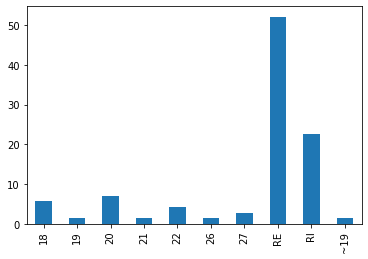

In [221]:
hist(esiti_unici) # i valori sono percentuali

### Più succintamente

Può essere utile "semplificare" i diversi esiti raggruppando nel valore `OK` tutti gli esiti vebralizzati e in `~` quelli rifiutati usando la funzione seguente 

In [227]:
def sempl(e):
    return 'OK' if starts_with_digit(e) else ('~' if e.startswith('~') else e)

In [228]:
esiti_unici_sempl = esiti_unici.apply(sempl)

In [229]:
count(esiti_unici_sempl)

,OK,RE,RI,~
#,17,37,16,1


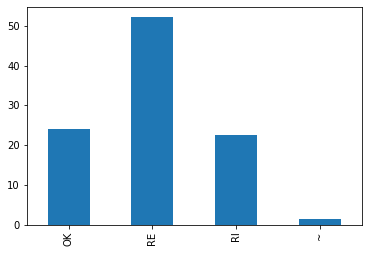

In [230]:
hist(esiti_unici_sempl)

## Pattern 

Invece di riassumere gli esiti relativi ad uno studente in un unico valore, può essere interessante conservare la storia di tutti gli esiti; la cella seguente definisce la variabile `pattern` aggregando in una *tupla* gli esiti raggruppati per numero di matricola.

In [232]:
pattern = sel.verbali.groupby('Matricola').Esito.agg(tuple)

La funzione seguente consente di ottenere un elenco dei pattern ordinato secondo la frequenza con cui compare:

In [244]:
def freq(_):
    perc = lambda _: (10000*_/sum(_)).astype(int)/100    
    return pd.DataFrame({'%': perc(_.value_counts().sort_values(ascending = False))})

In [249]:
freq(pattern).head(10) # ad esempio, i 10 più frequenti

,%
"(RE,)",28.16
"(RE, RE)",19.71
"(RI,)",19.71
"(18,)",5.63
"(RE, 20)",5.63
"(22,)",4.22
"(RI, RE)",2.81
"(RI, RI)",2.81
"(27,)",1.40
"(RE, ~19)",1.40


### Più succintamente

Come nel caso precedente, prima di costruire i pattern, può aver senso raccogliere gli esiti verbalizzati e rifiutati nei due valori `OK` e `~`

In [254]:
pattern_sempl = sel.verbali.Esito.map(sempl).groupby(sel.verbali.Matricola).agg(tuple)

In [255]:
freq(pattern_sempl)

,%
"(RE,)",28.16
"(RE, RE)",19.71
"(RI,)",19.71
"(OK,)",14.08
"(RE, OK)",8.45
"(RI, RI)",2.81
"(RI, RE)",2.81
"(RE, RI)",1.40
"(RI, OK)",1.40
"(RE, ~)",1.40


Una ulteriore visualizzazione può essere ottenuta tramite la seguente funzione

In [256]:
def hhist(_):
    perc = lambda _: (10000*_/sum(_)).astype(int)/100    
    perc(_.value_counts()).sort_values().plot.barh()

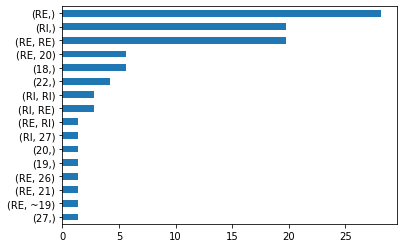

In [257]:
hhist(pattern)

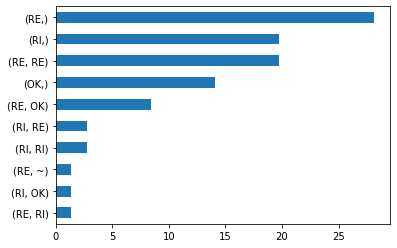

In [258]:
hhist(pattern_sempl)